<a href="https://colab.research.google.com/github/llunasanz/data-project-3/blob/feature%2Fdata_processing/data_cleaning_all_(PARTE_PCA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sweetviz

     |████████████████████████████████| 15.1 MB 4.7 MB/s 


In [ ]:
!pip3 install mglearn

     |████████████████████████████████| 540 kB 5.8 MB/s eta 0:00:01
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582637 sha256=4f78dc1ebbe9a3bb86dbb14dc8d7d077e8e651f267d7af2b28fc5f4cd16242fe
  Stored in directory: /home/lluna/.cache/pip/wheels/df/30/8a/1e2c8f144c9d411b0688f628d496d2db8f61b6d14bcedaa1df
Successfully built mglearn


## Importanción de Librerías

In [ ]:
import pandas as pd
#import pyspark as ps
import datetime as dt
import sweetviz as sv
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from sklearn.decomposition import PCA
import mglearn
import multiprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [ ]:
def days_hours_minutes(td):
    return td.days, td.seconds//3600, (td.seconds//60)%60

In [ ]:
def groupby_method(df, method: str):
    df_t = df.copy()
    dict_rename = {"loanamount": f"loanamount_{method}", 
               "totaldue": f"totaldue_{method}", 
               "termdays": f"termdays_{method}", 
               "diffcreaaprov": f"diffcreaaprov_{method}", 
               "diffpaid": f"diffpaid_{method}", 
               "diffclosecrea": f"diffclosecrea_{method}",
               "diffclose1rep": f"diffclose1rep_{method}", 
               "duration_ratio": f"duration_ratio_{method}"
              }
    df_t.rename(dict_rename, axis = 1, inplace = True)
    if method == "min":
        df_t = df_t.groupby(by=["customerid"]).min()
    if method == "1q":
        df_t = df_t.groupby(by=["customerid"]).quantile(.25)
    if method == "median":
        df_t = df_t.groupby(by=["customerid"]).median()
    if method == "3q":
        df_t = df_t.groupby(by=["customerid"]).quantile(.75)
    if method == "max":
        df_t = df_t.groupby(by=["customerid"]).max()
    
    
    return(df_t)

## CARGA Y LIMPIEZA DE DATOS

### Cargamos los datos de los diferentes CSV para su posterior limpieza de variables






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Usamos pandas para leer de los csv 
df_tr_demo = pd.read_csv('./data/train/train_datos_demograficos.csv')
df_ts_demo = pd.read_csv('./data/test/test_datos_demograficos.csv')

df_tr_previous = pd.read_csv('./data/train/train_previous_loan.csv')
df_ts_previous = pd.read_csv('./data/test/test_previous_loan.csv')

df_tr_performance = pd.read_csv('./data/train/train_performance.csv')
df_ts_performance = pd.read_csv('./data/test/test_performance.csv')

df_sample = pd.read_csv('./data/SampleSubmission.csv')

In [ ]:
df_ts_performance = df_ts_performance.merge(df_sample, on = "customerid", how = "left")
df_ts_performance.rename(columns = {"Good_Bad_flag": "good_bad_flag"}, inplace=True)

In [ ]:
# Concatenate
df_demo = pd.concat([df_tr_demo, df_ts_demo], axis = 0)
df_previous = pd.concat([df_tr_previous, df_ts_previous], axis = 0)
df_performance = pd.concat([df_tr_performance, df_ts_performance], axis = 0)

#### Previous

In [ ]:
# Previous
df_previous_t = df_previous.copy()

df_previous_t["diffcreaaprov"] = pd.to_datetime(
    df_previous_t.approveddate) - pd.to_datetime(df_previous_t.creationdate
)
df_previous_t.diffcreaaprov = df_previous_t.diffcreaaprov.dt.total_seconds()/3600

df_previous_t["diffpaid"] = pd.to_datetime(
    df_previous_t.firstrepaiddate) - pd.to_datetime(df_previous_t.firstduedate
)
df_previous_t.diffpaid = df_previous_t.diffpaid.dt.total_seconds()/3600

df_previous_t["diffclosecrea"] = pd.to_datetime(
    df_previous_t.closeddate) - pd.to_datetime(df_previous_t.creationdate
)
df_previous_t.diffclosecrea = df_previous_t.diffclosecrea.dt.total_seconds()/3600/24

df_previous_t["diffclose1rep"] = pd.to_datetime(
    df_previous_t.closeddate) - pd.to_datetime(df_previous_t.firstrepaiddate
)
df_previous_t.diffclose1rep = df_previous_t.diffclose1rep.dt.total_seconds()/3600/24

df_previous_t["duration_ratio"] = df_previous_t.diffclose1rep / df_previous_t.termdays
# df_previous_t.diffclosecrea = df_previous_t.diffclosecrea.dt.total_seconds()/3600


df_previous_t.referredby = list(map(lambda x: 0 if pd.isna(x) else 1, list(df_previous_t.referredby)))
# df_previous_t['termlength'] = pd.cut(df_previous_t['termdays'],[0,16,61,89], labels = ['short','medium','large'])


n_loans = list(df_previous_t[["customerid", "loannumber"]].groupby(by=["customerid"]).count()['loannumber'])
df_previous_t.drop(['systemloanid', "loannumber", 'creationdate', 'approveddate', 'firstduedate', 'firstrepaiddate', 'referredby', 'closeddate'], axis=1, inplace=True)


df_previous_min = groupby_method(df_previous_t, "min")

df_previous_max = groupby_method(df_previous_t, "max")

df_previous_median = groupby_method(df_previous_t, "median")

df_previous_1q = groupby_method(df_previous_t, "1q")

df_previous_3q = groupby_method(df_previous_t, "3q")


df_previous_median["nloans"] = n_loans
df_previous_t.reset_index(inplace = True)

df_previous_t

,index,customerid,loanamount,totaldue,termdays,diffcreaaprov,diffpaid,diffclosecrea,diffclose1rep,duration_ratio
0,0,8a2a81a74ce8c05d014cfb32a0da1049,10000.0,13000.0,30,1.002222,-296.138056,16.947407,0.010475,0.000349
1,1,8a2a81a74ce8c05d014cfb32a0da1049,10000.0,13000.0,30,1.003889,-96.000000,29.879120,2.614456,0.087149
2,2,8a2a81a74ce8c05d014cfb32a0da1049,20000.0,23800.0,30,1.001667,550.063056,52.515706,0.010521,0.000351
3,3,8a8588f35438fe12015444567666018e,10000.0,11500.0,15,1.003611,0.811944,14.340394,0.032743,0.002183
4,4,8a85890754145ace015429211b513e16,10000.0,11500.0,15,1.001944,285.143056,27.533947,0.007037,0.000469
...,...,...,...,...,...,...,...,...,...,...
24085,5902,8a858f085b494826015b54a0b2a1093b,10000.0,13000.0,30,1.006111,-145.801667,23.015891,0.010521,0.000351
24086,5903,8a858f565b683b56015b7391c2617960,10000.0,11500.0,15,1.003333,-148.707500,9.874734,0.010521,0.000701
24087,5904,8a858fab5b9105dc015b975e594e394a,10000.0,13000.0,30,1.018889,-298.957222,16.935683,0.007049,0.000235
24088,5905,8a858fcf5b39c3ba015b39c7691603e1,10000.0,13000.0,30,1.001667,-2.164722,29.669595,0.007060,0.000235


#### Demographic

In [ ]:
df_demo_t = df_demo.copy()

df_demo_t["age"] = max(pd.to_datetime(df_tr_performance.creationdate)) - pd.to_datetime(df_demo_t.birthdate)
df_demo_t.age = df_demo_t.age.dt.total_seconds()/3600/24/365

df_demo_t.employment_status_clients = list(map(lambda x: "Other" if pd.isna(x) else x, list(df_demo_t.employment_status_clients)))
df_demo_t.level_of_education_clients = list(map(lambda x: "Other" if pd.isna(x) else x, list(df_demo_t.level_of_education_clients)))

df_demo_t.drop(["bank_branch_clients", "birthdate", "longitude_gps", "latitude_gps"], axis = 1, inplace = True)
df_demo_t.drop_duplicates(subset=["customerid"], keep="last", inplace=True)

df_demo_t

,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,age
0,8a858e135cb22031015cbafc76964ebd,Savings,3.319219,6.528604,GT Bank,Other,Other,43.835380
1,8a858e275c7ea5ec015c82482d7c3996,Savings,3.325598,7.119403,Sterling Bank,Permanent,Other,31.544969
2,8a858e5b5bd99460015bdc95cd485634,Savings,5.746100,5.563174,Fidelity Bank,Other,Other,30.353188
3,8a858efd5ca70688015cabd1f1e94b55,Savings,3.362850,6.642485,GT Bank,Permanent,Other,26.051818
4,8a858e785acd3412015acd48f4920d04,Savings,8.455332,11.971410,GT Bank,Permanent,Other,34.712092
...,...,...,...,...,...,...,...,...
1482,8a858fc25bafabdc015bb47fda0323e5,Savings,3.481190,6.442728,GT Bank,Permanent,Other,41.325791
1483,8a858e245c214660015c3397e4db389a,Savings,4.738209,8.179723,GT Bank,Permanent,Other,26.786065
1484,8a858e8b5bc9e7e6015bcd7374077f0c,Savings,3.424825,6.455802,First Bank,Permanent,Other,29.153188
1485,8a858f2e5c699f3a015c77aa22ed7f23,Savings,3.318851,7.113212,FCMB,Permanent,Other,43.386065


#### Performance (train)

In [ ]:
df_tr_performance_t = df_tr_performance.copy()
# df_tr_performance_t['termlength'] = pd.cut(df_tr_performance_t['termdays'],[0,16,61,89], labels = ['short','medium','large'])
df_tr_performance_t.referredby = list(map(lambda x: 0 if pd.isna(x) else 1, list(df_tr_performance_t.referredby)))
df_tr_performance_t.good_bad_flag = list(map(lambda x: 0 if x == "Good" else 1, list(df_tr_performance_t.good_bad_flag)))
df_tr_performance_t["loan_due_ratio"] = df_tr_performance_t.loanamount/df_tr_performance_t.totaldue

df_tr_performance_t.drop(["systemloanid", "loannumber", "approveddate", "creationdate"], axis = 1, inplace = True)

df_tr_performance_t

,customerid,loanamount,totaldue,termdays,referredby,good_bad_flag,loan_due_ratio
0,8a2a81a74ce8c05d014cfb32a0da1049,30000.0,34500.0,30,0,0,0.869565
1,8a85886e54beabf90154c0a29ae757c0,15000.0,17250.0,30,0,0,0.869565
2,8a8588f35438fe12015444567666018e,20000.0,22250.0,15,0,0,0.898876
3,8a85890754145ace015429211b513e16,10000.0,11500.0,15,0,0,0.869565
4,8a858970548359cc0154883481981866,40000.0,44000.0,30,0,0,0.909091
...,...,...,...,...,...,...,...
4363,8a858e6d58b0cc520158beeb14b22a5a,10000.0,13000.0,30,0,1,0.769231
4364,8a858ee85cf400f5015cf44ab1c42d5c,10000.0,13000.0,30,0,1,0.769231
4365,8a858f365b2547f3015b284597147c94,10000.0,11500.0,15,0,1,0.869565
4366,8a858f935ca09667015ca0ee3bc63f51,10000.0,13000.0,30,1,1,0.769231


#### Merged data

In [ ]:
df_tr_all = df_tr_performance_t.merge(df_previous_median, on = "customerid", how = "left")
df_tr_all = df_tr_all.merge(df_previous_min, on = "customerid", how = "left")
df_tr_all = df_tr_all.merge(df_previous_max, on = "customerid", how = "left")
df_tr_all = df_tr_all.merge(df_previous_1q, on = "customerid", how = "left")
df_tr_all = df_tr_all.merge(df_previous_3q, on = "customerid", how = "left")
df_tr_all = df_tr_all.merge(df_demo_t, on = "customerid", how = "left")

df_tr_all.dropna(inplace=True)
# df_all[df_all.isna().any(axis=1)]

# df_tr_all.to_csv('/content/drive/MyDrive/DP3/data/merged_ts.csv')

#### Merged data test

In [ ]:
# df_ts_performance_t = df_ts_performance.copy()
# # df_tr_performance_t['termlength'] = pd.cut(df_tr_performance_t['termdays'],[0,16,61,89], labels = ['short','medium','large'])
# df_ts_performance_t.referredby = list(map(lambda x: 0 if pd.isna(x) else 1, list(df_ts_performance_t.referredby)))
# # df_ts_performance_t.good_bad_flag = list(map(lambda x: 0 if x == "Good" else 1, list(df_ts_performance_t.good_bad_flag)))
# df_ts_performance_t["loan_due_ratio"] = df_ts_performance_t.loanamount/df_ts_performance_t.totaldue

# df_ts_performance_t.drop(["systemloanid", "loannumber", "approveddate", "creationdate"], axis = 1, inplace = True)
# df_ts_performance_t.rename(columns = {"Good_Bad_flag": "good_bad_flag"}, inplace=True)

# df_ts_performance_t

In [ ]:
# df_ts_all = df_ts_performance_t.merge(df_previous_median, on = "customerid", how = "left")
# df_ts_all = df_ts_all.merge(df_previous_min, on = "customerid", how = "left")
# df_ts_all = df_ts_all.merge(df_previous_max, on = "customerid", how = "left")
# df_ts_all = df_ts_all.merge(df_previous_1q, on = "customerid", how = "left")
# df_ts_all = df_ts_all.merge(df_previous_3q, on = "customerid", how = "left")
# df_ts_all = df_ts_all.merge(df_demo_t, on = "customerid", how = "left")

# df_ts_all.dropna(inplace=True)
# # df_all[df_all.isna().any(axis=1)]

# df_ts_all

In [ ]:
# df_ts_all.to_csv('/content/drive/MyDrive/DP3/data/merged_ts.csv')

### All data merged

In [ ]:
df_tr_all.to_csv('/content/drive/MyDrive/DP3/data/merged_tr.csv')

In [ ]:
df_all = df_tr_all
df_all = df_all.sample(random_state = 73, frac = 1)
df_all.set_index(["customerid"], inplace=True)
# df_all.dropna(inplace=True)
# df_all.to_csv('/content/drive/MyDrive/DP3/data/merged.csv')

In [ ]:
# # Excluir a los usuarios que no son de Nigeria no marca ninguna diferencia
# df_all = df_all.loc[df_all.latitude_gps < 15]
# df_all = df_all.loc[df_all.latitude_gps > 3]
# df_all = df_all.loc[df_all.longitude_gps > 2]
# df_all = df_all.loc[df_all.longitude_gps < 15]

# One hot encoding

In [ ]:
df_all_t = df_all.copy()


df_all_t = df_all_t.join(pd.get_dummies(df_all.bank_account_type, prefix="bat", prefix_sep="_", drop_first = True))
df_all_t = df_all_t.join(pd.get_dummies(df_all.bank_name_clients, prefix="bnc", prefix_sep="_", drop_first = True))
df_all_t = df_all_t.join(pd.get_dummies(df_all.employment_status_clients, prefix="empl", prefix_sep="_", drop_first = True))
df_all_t = df_all_t.join(pd.get_dummies(df_all.level_of_education_clients, prefix="edu", prefix_sep="_", drop_first = True))
df_all_t.drop(["bank_account_type", 
               "bank_name_clients", 
               "employment_status_clients", 
               "level_of_education_clients"], 
              axis=1, 
              inplace=True
             )


df_all_t

,loanamount,totaldue,termdays,referredby,good_bad_flag,loan_due_ratio,loanamount_median,totaldue_median,termdays_median,diffcreaaprov_median,diffpaid_median,diffclosecrea_median,diffclose1rep_median,duration_ratio_median,nloans,loanamount_min,totaldue_min,termdays_min,diffcreaaprov_min,diffpaid_min,diffclosecrea_min,diffclose1rep_min,duration_ratio_min,loanamount_max,totaldue_max,termdays_max,diffcreaaprov_max,diffpaid_max,diffclosecrea_max,diffclose1rep_max,duration_ratio_max,loanamount_1q,totaldue_1q,termdays_1q,diffcreaaprov_1q,diffpaid_1q,diffclosecrea_1q,diffclose1rep_1q,duration_ratio_1q,loanamount_3q,totaldue_3q,termdays_3q,diffcreaaprov_3q,diffpaid_3q,diffclosecrea_3q,diffclose1rep_3q,duration_ratio_3q,longitude_gps,latitude_gps,age,bat_Other,bat_Savings,bnc_Diamond Bank,bnc_EcoBank,bnc_FCMB,bnc_Fidelity Bank,bnc_First Bank,bnc_GT Bank,bnc_Heritage Bank,bnc_Keystone Bank,bnc_Skye Bank,bnc_Stanbic IBTC,bnc_Standard Chartered,bnc_Sterling Bank,bnc_UBA,bnc_Union Bank,bnc_Unity Bank,bnc_Wema Bank,bnc_Zenith Bank,empl_Other,empl_Permanent,empl_Retired,empl_Self-Employed,empl_Student,empl_Unemployed,edu_Other,edu_Post-Graduate,edu_Primary,edu_Secondary
customerid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8a858e5b5bd99460015be71e03dc77ed,10000.0,11500.0,15,0,1,0.869565,10000.0,12250.0,22.5,1.002639,-170.323472,14.991337,0.007043,0.000352,2.0,10000.0,11500.0,15.0,1.001667,-326.541111,13.908924,0.007037,0.000235,10000.0,13000.0,30.0,1.003611,-14.105833,16.073750,0.007049,0.000470,10000.0,11875.0,18.75,1.002153,-248.432292,14.450130,0.007040,0.000293,10000.0,12625.0,26.25,1.003125,-92.214653,15.532543,0.007046,0.000411,3.315651,6.463566,23.435380,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
8a858f9a5c885f42015c8c56555f6071,10000.0,13000.0,30,0,0,0.769231,10000.0,13000.0,30.0,1.018889,-104.520833,25.989282,0.007049,0.000235,1.0,10000.0,13000.0,30.0,1.018889,-104.520833,25.989282,0.007049,0.000235,10000.0,13000.0,30.0,1.018889,-104.520833,25.989282,0.007049,0.000235,10000.0,13000.0,30.00,1.018889,-104.520833,25.989282,0.007049,0.000235,10000.0,13000.0,30.00,1.018889,-104.520833,25.989282,0.007049,0.000235,6.984459,4.846333,32.084695,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
8a858f2f5af5d835015af5db88300242,10000.0,11500.0,15,0,1,0.869565,10000.0,11500.0,15.0,1.002083,223.506806,23.854531,0.008791,0.000586,4.0,10000.0,11500.0,15.0,1.001667,-342.473611,0.054757,0.007037,0.000469,10000.0,11500.0,15.0,1.005556,547.847500,37.331806,0.010521,0.000701,10000.0,11500.0,15.00,1.001875,54.694931,16.694592,0.007054,0.000470,10000.0,11500.0,15.00,1.003056,331.908750,28.433845,0.010521,0.000701,3.422864,6.441426,35.106613,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
8a858ff25a617906015a6644377f536f,30000.0,34500.0,30,0,0,0.869565,20000.0,21900.0,15.0,1.001944,-53.777222,12.482593,0.010521,0.000701,7.0,10000.0,11500.0,15.0,1.001667,-161.258889,7.861458,0.007037,0.000235,20000.0,23000.0,30.0,1.005833,19.387778,31.820382,0.010544,0.000703,10000.0,11500.0,15.00,1.001806,-107.923194,11.004624,0.008779,0.000585,20000.0,22250.0,15.00,1.002778,15.266111,15.242205,0.010527,0.000702,4.593105,8.485414,30.753188,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
8a858e085cc5b826015cc60650982c6c,10000.0,11500.0,15,0,0,0.869565,10000.0,13000.0,30.0,1.018889,7.723889,30.605231,0.007037,0.000235,1.0,10000.0,13000.0,30.0,1.018889,7.723889,30.605231,0.007037,0.000235,10000.0,13000.0,30.0,1.018889,7.723889,30.605231,0.007037,0.000235,10000.0,13000.0,30.00,1.018889,7.723889,30.605231,0.007037,0.000235,10000.0,13000.0,30.00,1.018889,7.723889,30.605231,0.007037,0.000235,7.638862,9.000798,44.731270,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

# Normalize

In [ ]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df_all_t.values)
df_all_t = pd.DataFrame(df_scaled, index=df_all_t.index, columns=df_all_t.columns)

df_all_t.to_csv('./data/merged.csv')

In [ ]:
df_all_t.head()

,loanamount,totaldue,termdays,referredby,good_bad_flag,loan_due_ratio,loanamount_median,totaldue_median,termdays_median,diffcreaaprov_median,diffpaid_median,diffclosecrea_median,diffclose1rep_median,duration_ratio_median,nloans,loanamount_min,totaldue_min,termdays_min,diffcreaaprov_min,diffpaid_min,diffclosecrea_min,diffclose1rep_min,duration_ratio_min,loanamount_max,totaldue_max,termdays_max,diffcreaaprov_max,diffpaid_max,diffclosecrea_max,diffclose1rep_max,duration_ratio_max,loanamount_1q,totaldue_1q,termdays_1q,diffcreaaprov_1q,diffpaid_1q,diffclosecrea_1q,diffclose1rep_1q,duration_ratio_1q,loanamount_3q,totaldue_3q,termdays_3q,diffcreaaprov_3q,diffpaid_3q,diffclosecrea_3q,diffclose1rep_3q,duration_ratio_3q,longitude_gps,latitude_gps,age,bat_Other,bat_Savings,bnc_Diamond Bank,bnc_EcoBank,bnc_FCMB,bnc_Fidelity Bank,bnc_First Bank,bnc_GT Bank,bnc_Heritage Bank,bnc_Keystone Bank,bnc_Skye Bank,bnc_Stanbic IBTC,bnc_Standard Chartered,bnc_Sterling Bank,bnc_UBA,bnc_Union Bank,bnc_Unity Bank,bnc_Wema Bank,bnc_Zenith Bank,empl_Other,empl_Permanent,empl_Retired,empl_Self-Employed,empl_Student,empl_Unemployed,edu_Other,edu_Post-Graduate,edu_Primary,edu_Secondary
customerid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8a858e5b5bd99460015be71e03dc77ed,0.0,0.025818,0.0,0.0,1.0,0.434783,0.142857,0.166453,0.166667,0.000042,0.165887,0.102101,0.000158,0.000503,0.04,0.259259,0.226442,0.000000,0.000031,0.285850,0.226041,0.000325,0.000648,0.090909,0.116279,0.2,0.000067,0.080014,0.042027,1.635220e-07,4.987172e-05,0.2,0.184211,0.083333,0.000029,0.224811,0.152854,0.000316,0.000796,0.111111,0.145042,0.214286,0.000056,0.126508,0.071913,2.887014e-07,2.579184e-04,0.074522,0.216477,0.060310,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8a858f9a5c885f42015c8c56555f6071,0.0,0.051635,0.2,0.0,0.0,0.000000,0.142857,0.185659,0.333333,0.000492,0.184759,0.177344,0.000158,0.000246,0.00,0.259259,0.268636,0.333333,0.000508,0.434954,0.423067,0.000325,0.000649,0.090909,0.116279,0.2,0.000473,0.070167,0.068062,1.635220e-07,8.175692e-08,0.2,0.218045,0.333333,0.000492,0.289479,0.275417,0.000316,0.000632,0.111111,0.152954,0.285714,0.000492,0.124136,0.120538,3.849352e-07,5.637560e-07,0.388477,0.048080,0.311164,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8a858f2f5af5d835015af5db88300242,0.0,0.025818,0.0,0.0,1.0,0.434783,0.142857,0.147247,0.000000,0.000027,0.278838,0.162739,0.000239,0.001016,0.12,0.259259,0.226442,0.000000,0.000031,0.275150,0.000085,0.000325,0.001306,0.090909,0.092221,0.0,0.000118,0.141222,0.097844,4.922011e-05,9.892588e-05,0.2,0.172932,0.000000,0.000021,0.361023,0.176693,0.000316,0.001292,0.111111,0.121308,0.000000,0.000054,0.208234,0.131905,1.158655e-04,6.821448e-04,0.083696,0.214171,0.398808,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8a858ff25a617906015a6644377f536f,0.4,0.421687,0.2,0.0,0.0,0.434783,0.428571,0.413572,0.000000,0.000023,0.199313,0.084938,0.000320,0.001268,0.24,0.259259,0.226442,0.000000,0.000031,0.396850,0.127409,0.000325,0.000648,0.272727,0.276664,0.2,0.000126,0.083663,0.083373,4.954716e-05,9.925291e-05,0.2,0.172932,0.000000,0.000019,0.287950,0.116257,0.000397,0.001615,0.333333,0.348101,0.000000,0.000046,0.147219,0.070563,1.160580e-04,6.827085e-04,0.183839,0.427004,0.272547,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8a858e085cc5b826015cc60650982c6c,0.0,0.025818,0.0,0.0,0.0,0.434783,0.142857,0.185659,0.333333,0.000492,0.216951,0.208925,0.000157,0.000246,0.00,0.259259,0.268636,0.333333,0.000508,0.510336,0.498351,0.000325,0.000648,0.090909,0.116279,0.2,0.000473,0.082392,0.080182,0.000000e+00,0.000000e+00,0.2,0.218045,0.333333,0.000492,0.339917,0.324445,0.000315,0.000631,0.111111,0.152954,0.285714,0.000492,0.145765,0.142002,0

# PCA

In [ ]:
df_pca = df_all_t
df_pca.head()

,loanamount,totaldue,termdays,referredby,good_bad_flag,loan_due_ratio,loanamount_median,totaldue_median,termdays_median,diffcreaaprov_median,diffpaid_median,diffclosecrea_median,diffclose1rep_median,duration_ratio_median,nloans,loanamount_min,totaldue_min,termdays_min,diffcreaaprov_min,diffpaid_min,diffclosecrea_min,diffclose1rep_min,duration_ratio_min,loanamount_max,totaldue_max,termdays_max,diffcreaaprov_max,diffpaid_max,diffclosecrea_max,diffclose1rep_max,duration_ratio_max,loanamount_1q,totaldue_1q,termdays_1q,diffcreaaprov_1q,diffpaid_1q,diffclosecrea_1q,diffclose1rep_1q,duration_ratio_1q,loanamount_3q,totaldue_3q,termdays_3q,diffcreaaprov_3q,diffpaid_3q,diffclosecrea_3q,diffclose1rep_3q,duration_ratio_3q,longitude_gps,latitude_gps,age,bat_Other,bat_Savings,bnc_Diamond Bank,bnc_EcoBank,bnc_FCMB,bnc_Fidelity Bank,bnc_First Bank,bnc_GT Bank,bnc_Heritage Bank,bnc_Keystone Bank,bnc_Skye Bank,bnc_Stanbic IBTC,bnc_Standard Chartered,bnc_Sterling Bank,bnc_UBA,bnc_Union Bank,bnc_Unity Bank,bnc_Wema Bank,bnc_Zenith Bank,empl_Other,empl_Permanent,empl_Retired,empl_Self-Employed,empl_Student,empl_Unemployed,edu_Other,edu_Post-Graduate,edu_Primary,edu_Secondary
customerid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8a858e5b5bd99460015be71e03dc77ed,0.0,0.025818,0.0,0.0,1.0,0.434783,0.142857,0.166453,0.166667,0.000042,0.165887,0.102101,0.000158,0.000503,0.04,0.259259,0.226442,0.000000,0.000031,0.285850,0.226041,0.000325,0.000648,0.090909,0.116279,0.2,0.000067,0.080014,0.042027,1.635220e-07,4.987172e-05,0.2,0.184211,0.083333,0.000029,0.224811,0.152854,0.000316,0.000796,0.111111,0.145042,0.214286,0.000056,0.126508,0.071913,2.887014e-07,2.579184e-04,0.074522,0.216477,0.060310,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8a858f9a5c885f42015c8c56555f6071,0.0,0.051635,0.2,0.0,0.0,0.000000,0.142857,0.185659,0.333333,0.000492,0.184759,0.177344,0.000158,0.000246,0.00,0.259259,0.268636,0.333333,0.000508,0.434954,0.423067,0.000325,0.000649,0.090909,0.116279,0.2,0.000473,0.070167,0.068062,1.635220e-07,8.175692e-08,0.2,0.218045,0.333333,0.000492,0.289479,0.275417,0.000316,0.000632,0.111111,0.152954,0.285714,0.000492,0.124136,0.120538,3.849352e-07,5.637560e-07,0.388477,0.048080,0.311164,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8a858f2f5af5d835015af5db88300242,0.0,0.025818,0.0,0.0,1.0,0.434783,0.142857,0.147247,0.000000,0.000027,0.278838,0.162739,0.000239,0.001016,0.12,0.259259,0.226442,0.000000,0.000031,0.275150,0.000085,0.000325,0.001306,0.090909,0.092221,0.0,0.000118,0.141222,0.097844,4.922011e-05,9.892588e-05,0.2,0.172932,0.000000,0.000021,0.361023,0.176693,0.000316,0.001292,0.111111,0.121308,0.000000,0.000054,0.208234,0.131905,1.158655e-04,6.821448e-04,0.083696,0.214171,0.398808,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8a858ff25a617906015a6644377f536f,0.4,0.421687,0.2,0.0,0.0,0.434783,0.428571,0.413572,0.000000,0.000023,0.199313,0.084938,0.000320,0.001268,0.24,0.259259,0.226442,0.000000,0.000031,0.396850,0.127409,0.000325,0.000648,0.272727,0.276664,0.2,0.000126,0.083663,0.083373,4.954716e-05,9.925291e-05,0.2,0.172932,0.000000,0.000019,0.287950,0.116257,0.000397,0.001615,0.333333,0.348101,0.000000,0.000046,0.147219,0.070563,1.160580e-04,6.827085e-04,0.183839,0.427004,0.272547,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8a858e085cc5b826015cc60650982c6c,0.0,0.025818,0.0,0.0,0.0,0.434783,0.142857,0.185659,0.333333,0.000492,0.216951,0.208925,0.000157,0.000246,0.00,0.259259,0.268636,0.333333,0.000508,0.510336,0.498351,0.000325,0.000648,0.090909,0.116279,0.2,0.000473,0.082392,0.080182,0.000000e+00,0.000000e+00,0.2,0.218045,0.333333,0.000492,0.339917,0.324445,0.000315,0.000631,0.111111,0.152954,0.285714,0.000492,0.145765,0.142002,0

In [ ]:
# Separamos las características de la variable objetivo de la variable target
X = df_pca.drop(["good_bad_flag"], axis = 1)
y = df_pca.good_bad_flag

features = X.columns

# Standardizing the features
X = StandardScaler().fit_transform(X)

# Sacamos el DataFrame con las variables estandarizadas
pd.DataFrame(data = X, columns = features).head()

,loanamount,totaldue,termdays,referredby,loan_due_ratio,loanamount_median,totaldue_median,termdays_median,diffcreaaprov_median,diffpaid_median,diffclosecrea_median,diffclose1rep_median,duration_ratio_median,nloans,loanamount_min,totaldue_min,termdays_min,diffcreaaprov_min,diffpaid_min,diffclosecrea_min,diffclose1rep_min,duration_ratio_min,loanamount_max,totaldue_max,termdays_max,diffcreaaprov_max,diffpaid_max,diffclosecrea_max,diffclose1rep_max,duration_ratio_max,loanamount_1q,totaldue_1q,termdays_1q,diffcreaaprov_1q,diffpaid_1q,diffclosecrea_1q,diffclose1rep_1q,duration_ratio_1q,loanamount_3q,totaldue_3q,termdays_3q,diffcreaaprov_3q,diffpaid_3q,diffclosecrea_3q,diffclose1rep_3q,duration_ratio_3q,longitude_gps,latitude_gps,age,bat_Other,bat_Savings,bnc_Diamond Bank,bnc_EcoBank,bnc_FCMB,bnc_Fidelity Bank,bnc_First Bank,bnc_GT Bank,bnc_Heritage Bank,bnc_Keystone Bank,bnc_Skye Bank,bnc_Stanbic IBTC,bnc_Standard Chartered,bnc_Sterling Bank,bnc_UBA,bnc_Union Bank,bnc_Unity Bank,bnc_Wema Bank,bnc_Zenith Bank,empl_Other,empl_Permanent,empl_Retired,empl_Self-Employed,empl_Student,empl_Unemployed,edu_Other,edu_Post-Graduate,edu_Primary,edu_Secondary
0,-0.725479,-0.815979,-1.237069,-0.394714,0.850253,-0.486896,-0.510842,-0.352324,-0.041931,-0.767062,-0.861703,-0.085538,-0.095299,-0.592522,0.119702,-0.361360,-0.868688,-0.033477,-0.789662,-0.261516,-0.035539,-0.052616,-0.668084,-0.633429,-0.019735,-0.124919,-0.260263,-0.858949,-0.300525,-0.279175,-0.288595,-0.441726,-0.638571,-0.038596,-0.980114,-0.623516,-0.054918,-0.072833,-0.604818,-0.588375,-0.097684,-0.053849,-0.436672,-0.974668,-0.152844,-0.176297,-0.772622,-0.461627,-1.562690,-0.505774,0.528759,-0.269571,-0.19344,-0.167477,-0.154632,-0.389218,1.313494,-0.069851,-0.066426,-0.162298,-0.190852,-0.062818,-0.110315,-0.292562,-0.073119,-0.037272,-0.0747,-0.277385,-0.422462,0.631125,-0.040263,-0.304052,-0.182901,-0.120597,0.398228,-0.124485,-0.040263,-0.139879
1,-0.725479,-0.690330,0.064396,-0.394714,-1.041194,-0.486896,-0.385019,0.675188,-0.015210,-0.357814,0.341413,-0.085527,-0.103154,-0.866310,0.119702,0.707483,1.138296,-0.002687,0.281832,0.945251,-0.035507,-0.052573,-0.668084,-0.633429,-0.019735,-0.117613,-0.510797,-0.306742,-0.300525,-0.280639,-0.288595,-0.038091,0.928863,-0.009330,-0.093349,0.647406,-0.054896,-0.078455,-0.604818,-0.545083,0.336522,-0.030777,-0.499424,0.009978,-0.152843,-0.180439,1.218011,-1.672605,-0.160537,-0.505774,0.528759,-0.269571,-0.19344,-0.167477,-0.154632,2.569252,-0.761328,-0.069851,-0.066426,-0.162298,-0.190852,-0.062818,-0.110315,-0.292562,-0.073119,-0.037272,-0.0747,-0.277385,-0.422462,0.631125,-0.040263,-0.304052,-0.182901,-0.120597,0.398228,-0.124485,-0.040263,-0.139879
2,-0.725479,-0.815979,-1.237069,-0.394714,0.850253,-0.486896,-0.636665,-1.379836,-0.042845,1.682296,0.107883,-0.082114,-0.079641,-0.044946,0.119702,-0.361360,-0.868688,-0.033477,-0.866553,-1.645476,-0.035539,-0.025996,-0.668084,-0.762563,-1.239093,-0.123989,1.296873,0.324936,-0.300059,-0.277733,-0.288595,-0.576271,-1.161049,-0.039081,0.887719,-0.376311,-0.054881,-0.055818,-0.604818,-0.718254,-1.400300,-0.053950,1.726019,0.240167,-0.151272,-0.169469,-0.714451,-0.478206,0.329350,-0.505774,0.528759,-0.269571,-0.19344,-0.167477,-0.154632,2.569252,-0.761328,-0.069851,-0.066426,-0.162298,-0.190852,-0.062818,-0.110315,-0.292562,-0.073119,-0.037272,-0.0747,-0.277385,-0.422462,0.631125,-0.040263,-0.304052,-0.182901,-0.120597,0.398228,-0.124485,-0.040263,-0.139879
3,1.136380,1.110637,0.064396,-0.394714,0.850253,1.374935,1.108078,-1.379836,-0.043073,-0.042223,-1.136147,-0.078723,-0.071915,0.776419,0.119702,-0.361360,-0.868688,-0.033477,0.008008,-0.865627,-0.035539,-0.052616,0.301047,0.227462,-0.019735,-0.123856,-0.167454,0.017999,-0.300056,-0.277724,-0.288595,-0.576271,-1.161049,-0.039203,-0.114314,-1.003004,-0.050442,-0.044759,0.684883,0.522808,-1.400300,-0.054357,0.111394,-1.002007,-0.151269,-0.169460,-0.079497,1.052324,-0.376390,-0.505774,0.528759,-0.269571,-0.19344,-0.167477,-0.154632,2.56925

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## PCA3 Componentes principales (visualización)


In [ ]:
# Asignamos el número de dimensiones que queremos utilizar
pca = PCA(n_components = 2)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'], index = df_all_t.index)



In [ ]:
# Mostramos los heads del principal DF y de la variable target
principalDf.head()


,principal component 1,principal component 2
customerid,,
8a858e5b5bd99460015be71e03dc77ed,-2.254069,-2.132407
8a858f9a5c885f42015c8c56555f6071,-1.996036,1.525319
8a858f2f5af5d835015af5db88300242,-2.322617,-0.491245
8a858ff25a617906015a6644377f536f,0.814158,-2.932280
8a858e085cc5b826015cc60650982c6c,-2.005070,2.454843


In [ ]:
# Unimos la variable target al DataFrame

finalDf = pd.concat([principalDf, df_all_t[['good_bad_flag']]], axis = 1)
finalDf

,principal component 1,principal component 2,good_bad_flag
customerid,,,
8a858e5b5bd99460015be71e03dc77ed,-2.254069,-2.132407,1.0
8a858f9a5c885f42015c8c56555f6071,-1.996036,1.525319,0.0
8a858f2f5af5d835015af5db88300242,-2.322617,-0.491245,1.0
8a858ff25a617906015a6644377f536f,0.814158,-2.932280,0.0
8a858e085cc5b826015cc60650982c6c,-2.005070,2.454843,0.0
...,...,...,...
8a8589b953bc23f70153c7bc036a2932,5.791100,-0.790536,0.0
8a858e3c5853733801585dadb1334a2e,-2.295556,-2.412784,0.0
8a858f98560bbe110156217f2b324081,-0.438250,6.020145,0.0


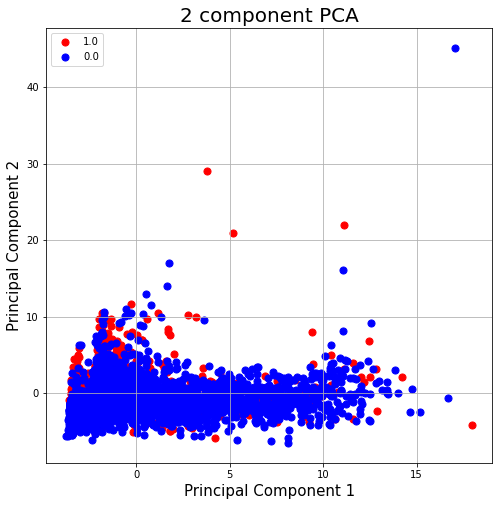

In [ ]:
# Usamos esta gráfica para ver la distribución de los dos componentes principales
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1.0, 0.0]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['good_bad_flag'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Podemos ver que los dos componentes principales no son suficientes para identificar las dos categorías que tenemos en la variable "good_bad_flag".
Pasaremo entonces a buscar métodos mediante los cuales el PCA nos aporte más información.

## PCA todas las variables 




In [ ]:
# Creamos la instancia del modelo
pca1 = PCA()

# Adaptamos las variables
X_train1 = pca1.fit_transform(X_train)
X_test1 = pca1.transform(X_test)

In [ ]:
#Vamos a buscar la varianza dependiendo de la cantidad de componentes que usemos (n)
explained_variance = pca1.explained_variance_ratio_
print(explained_variance)

[1.65101006e-01 9.37867884e-02 7.45405345e-02 6.14039780e-02
 5.23584007e-02 3.18574847e-02 2.49032888e-02 2.24085691e-02
 1.94834770e-02 1.79270652e-02 1.73599424e-02 1.63448387e-02
 1.59617758e-02 1.44775746e-02 1.43210398e-02 1.41936414e-02
 1.40895353e-02 1.38685870e-02 1.37374326e-02 1.33914751e-02
 1.32902884e-02 1.31511498e-02 1.31051659e-02 1.29304317e-02
 1.27286464e-02 1.25915920e-02 1.24086036e-02 1.23828217e-02
 1.20708324e-02 1.19398576e-02 1.18374934e-02 1.13964732e-02
 1.10463786e-02 1.08859490e-02 1.05078138e-02 1.01361242e-02
 9.27812924e-03 9.18339789e-03 8.94486993e-03 7.22278082e-03
 6.97888487e-03 6.60984971e-03 5.60277652e-03 5.32198082e-03
 4.68016601e-03 4.12124252e-03 3.88329987e-03 3.20354944e-03
 2.42929097e-03 2.27625052e-03 2.20441256e-03 1.60364104e-03
 1.52761463e-03 1.48215052e-03 1.24552376e-03 1.20841709e-03
 1.13261052e-03 1.04675760e-03 9.47241973e-04 7.05203169e-04
 5.46767647e-04 4.83140578e-04 4.31079873e-04 3.61778866e-04
 3.21616367e-04 2.435689

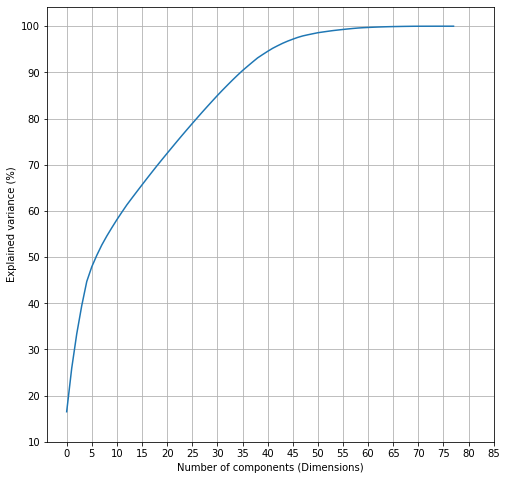

In [ ]:
# Pintamos el gráfico que nos permite ver el % de varianza dependiendo del número de componentes que usemos
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
plt.plot(np.cumsum(pca1.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")
plt.xticks(range(0, 90, 5))
plt.yticks(range(10, 110, 10))
ax.grid()

De la explicación de varianza vemos que de la primera variable depende el 16% de la varianza. Además podemos reconocer por el gráfico que necesitaríamos unas 26 componentes para superar el 80% de la variabilidad

In [ ]:
# Aplicamos un Random forest para conocer la accuracy de la predicción

from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier(max_depth=2, random_state=0)
logistic_regresion_classifier = LogisticRegression(random_state=0, 
                                                   max_iter=5000, 
                                                   C = 50, 
                                                   solver = 'liblinear'
                                                  ).fit(X_train, y_train)

random_forest_classifier.fit(X_train1, y_train)
logistic_regresion_classifier.fit(X_train1, y_train)

# Predecimos los resultados del test set
y_pred1 = random_forest_classifier.predict(X_test1)
y_pred2 = logistic_regresion_classifier.predict(X_test1)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm1 = confusion_matrix(y_test, y_pred1)
cm2 = confusion_matrix(y_test, y_pred2)
print('Confusion matrix Random forest\n', cm1)
print('Random forest score: ', accuracy_score(y_test, y_pred1))

# all parameters not specified are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'

#  Make an instance of the Model
LR_classifier = LogisticRegression(solver = 'lbfgs')


# Predict for various 
print('---------------------------------------------')
print('Confusion matrix logistic regresion \n', cm2)
print('Logistic regresion score:', logistic_regresion_classifier.score(X_test1, y_test))


Confusion matrix Random forest
 [[676   0]
 [189   0]]
Random forest score:  0.7815028901734105
---------------------------------------------
Confusion matrix logistic regresion 
 [[674   2]
 [187   2]]
Logistic regresion score: 0.7815028901734105


## PCA Componentes 80% variabilidad





Vamos a usar el PCA con n numero de componentes que cumplan el 80% de varianza


In [ ]:
pca2 = PCA(n_components=.80)

X_train2 = pca2.fit_transform(X_train)
X_test2 = pca2.transform(X_test)


In [ ]:
# all parameters not specified are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'
logisticRegr = LogisticRegression(solver = 'lbfgs')

In [ ]:

# Aplicamos un Random forest para conocer la accuracy de la predicción

from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier(max_depth=2, random_state=0)
logistic_regresion_classifier = LogisticRegression(random_state=0, 
                                                   max_iter=5000, 
                                                   C = 50, 
                                                   solver = 'liblinear'
                                                  ).fit(X_train, y_train)

random_forest_classifier.fit(X_train2, y_train)
logistic_regresion_classifier.fit(X_train2, y_train)

# Predecimos los resultados del test set
y_pred1 = random_forest_classifier.predict(X_test2)
y_pred2 = logistic_regresion_classifier.predict(X_test2)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm1 = confusion_matrix(y_test, y_pred1)
cm2 = confusion_matrix(y_test, y_pred2)
print('Confusion matrix Random forest\n', cm1)
print('Random forest score: ', accuracy_score(y_test, y_pred1))

# all parameters not specified are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'

#  Make an instance of the Model
LR_classifier = LogisticRegression(solver = 'lbfgs')


# Predict for various 
print('---------------------------------------------')
print('Confusion matrix logistic regresion \n', cm2)
print('Logistic regresion score:', logistic_regresion_classifier.score(X_test2, y_test))

Confusion matrix Random forest
 [[676   0]
 [189   0]]
Random forest score:  0.7815028901734105
---------------------------------------------
Confusion matrix logistic regresion 
 [[676   0]
 [189   0]]
Logistic regresion score: 0.7815028901734105


# Classification (using all variables)

In [ ]:
# Porcentaje que conviene superar
100 - df_tr_all.good_bad_flag.sum()/len(df_tr_all.good_bad_flag)*100

78.22895159440239

## Train test sets

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image 
from pydot import graph_from_dot_data
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
X = np.array(df_all_t.drop(["good_bad_flag"], axis = 1))
y = np.array(df_all_t.good_bad_flag)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42);

In [ ]:
# Porcentaje que conviene superar
100 - df_tr_all.good_bad_flag.sum()/len(df_tr_all.good_bad_flag)*100

78.22895159440239

## Logistic regression

In [ ]:
clf = LogisticRegression(random_state=0, 
                         max_iter=5000, 
                         C = 50, 
                         solver = 'liblinear'
                        ) \
        .fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[657,  19],
       [159,  30]])

In [ ]:
TP = confusion_matrix(y_test, y_pred)[0][0]
TN = confusion_matrix(y_test, y_pred)[1][1]
FP = confusion_matrix(y_test, y_pred)[0][1]
FN = confusion_matrix(y_test, y_pred)[1][0]

(TP+TN)/(TP+TN+FP+FN)

0.7942196531791907

In [ ]:
# Recall
TP/(TP+FN)*100

80.51470588235294

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=15, weights='uniform')

neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred)

array([[670,   6],
       [180,   9]])

In [ ]:
TP = confusion_matrix(y_test, y_pred)[0][0]
TN = confusion_matrix(y_test, y_pred)[1][1]
FP = confusion_matrix(y_test, y_pred)[0][1]
FN = confusion_matrix(y_test, y_pred)[1][0]

(TP+TN)/(TP+TN+FP+FN)

0.784971098265896

## Tree

In [ ]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Test data size = ' + str(X_test.shape))
print('Test target size = ' + str(y_test.shape))

Train data size = (3460, 78)
Train target size = (3460,)
Test data size = (865, 78)
Test target size = (865,)


In [ ]:
model = DecisionTreeClassifier(random_state = 1, max_depth=1000, min_samples_leaf=6, min_samples_split=2)
clf = model.fit(X_train, y_train)
clf

DecisionTreeClassifier(max_depth=1000, min_samples_leaf=6, random_state=1)

In [ ]:
from sklearn import tree

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as acc

y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[569, 107],
       [141,  48]])

In [ ]:
TP = confusion_matrix(y_test, y_pred)[0][0]
TN = confusion_matrix(y_test, y_pred)[1][1]
FP = confusion_matrix(y_test, y_pred)[0][1]
FN = confusion_matrix(y_test, y_pred)[1][0]

(TP+TN)/(TP+TN+FP+FN)

0.7132947976878613

In [ ]:
# fn=list(X.columns)
# cn=list("good_bad_flag")
# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
# tree.plot_tree(clf,
#                feature_names = fn, 
#                class_names=cn,
#                filled = True);

## Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, random_state = 1)
model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=1000, random_state=1)

In [ ]:
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[638,  38],
       [147,  42]])

In [ ]:
TP = confusion_matrix(y_test, y_pred)[0][0]
TN = confusion_matrix(y_test, y_pred)[1][1]
FP = confusion_matrix(y_test, y_pred)[0][1]
FN = confusion_matrix(y_test, y_pred)[1][0]

(TP+TN)/(TP+TN+FP+FN)

0.7861271676300579

# XGBoost

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(random_state = 73)

In [ ]:
model.fit(X_train, 
          np.array(y_train), 
          eval_metric = "auc", 
          eval_set=[(X_test, y_test)],
          early_stopping_rounds = 25,
          verbose=True)

# More info: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

[0]	validation_0-auc:0.66210
[1]	validation_0-auc:0.68688
[2]	validation_0-auc:0.69439
[3]	validation_0-auc:0.70272
[4]	validation_0-auc:0.70986
[5]	validation_0-auc:0.70711
[6]	validation_0-auc:0.69426
[7]	validation_0-auc:0.68957
[8]	validation_0-auc:0.69292
[9]	validation_0-auc:0.69264
[10]	validation_0-auc:0.69710
[11]	validation_0-auc:0.69828
[12]	validation_0-auc:0.69490
[13]	validation_0-auc:0.69540
[14]	validation_0-auc:0.69106
[15]	validation_0-auc:0.68893
[16]	validation_0-auc:0.68465
[17]	validation_0-auc:0.68463
[18]	validation_0-auc:0.68827
[19]	validation_0-auc:0.68861
[20]	validation_0-auc:0.68776
[21]	validation_0-auc:0.68969
[22]	validation_0-auc:0.68980
[23]	validation_0-auc:0.69088
[24]	validation_0-auc:0.69624
[25]	validation_0-auc:0.69477
[26]	validation_0-auc:0.69321
[27]	validation_0-auc:0.69505
[28]	validation_0-auc:0.69370


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=73,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[636,  40],
       [147,  42]])

In [ ]:
TP = confusion_matrix(y_test, y_pred)[0][0]
TN = confusion_matrix(y_test, y_pred)[1][1]
FP = confusion_matrix(y_test, y_pred)[0][1]
FN = confusion_matrix(y_test, y_pred)[1][0]

(TP+TN)/(TP+TN+FP+FN)

0.7838150289017342

# Fin